## Load Dataset

In [ ]:
!pip install kaggle

In [ ]:
!mkdir /root/.config/kaggle
!echo "{\"username\":\"USERNAME\",\"key\":\"KEY\"}" > /root/.config/kaggle/kaggle.json
!cat /root/.config/kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.config/kaggle’: File exists
{"username":"salavatfayzullin","key":"112f41749da4d2b26ec2d7e752619732"}


In [ ]:
import os
import zipfile
from kaggle.api.kaggle_api_extended import KaggleApi

# API Initialization
api = KaggleApi()
api.authenticate()

# Dataset loading
competition_name = "ieee-fraud-detection"
api.competition_download_files(competition_name, path="./data")

# Extracting
with zipfile.ZipFile(f"./data/{competition_name}.zip", 'r') as zip_ref:
    zip_ref.extractall("./data")

## Necessary dependencies

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns

## Imputing

In [2]:
target = None

def handle_nan_efficiently(transaction_path, identity_path, missing_threshold=0.7):
    """Handle missing values in IEEE fraud dataset efficiently"""
    global target

    # 1. Load data with optimized dtypes
    transaction = pd.read_csv(transaction_path, dtype={
        'TransactionID': 'int32',
        'TransactionDT': 'int32',
        'TransactionAmt': 'float32',
        'isFraud': 'int8'
    })


    identity = pd.read_csv(identity_path, dtype={
        'TransactionID': 'int32',
        'id_01': 'float32',
        'id_02': 'float32',
        'DeviceType': 'category',
        'DeviceInfo': 'category'
    })

    # 2. Merge datasets
    df = pd.merge(transaction, identity, on='TransactionID', how='left')
    target = df['isFraud']  # Сохраняем целевую переменную
    # df = df.drop(columns=['isFraud'])

    # 3. Column-wise missing value handling
    # First pass: Identify columns to drop
    cols_to_drop = [
        col for col in df.columns
        if df[col].isna().mean() > missing_threshold
    ]
    df = df.drop(columns=cols_to_drop)

    # Second pass: Handle remaining NaNs
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            # Use direct assignment instead of inplace
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
            # Downcast after filling
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            # Convert to categorical and handle NaNs
            df[col] = df[col].astype('category')
            if df[col].isna().any():
                df[col] = (
                    df[col]
                    .cat.add_categories('MISSING')
                    .fillna('MISSING')
                )

    # 4. Final memory optimization
    df = df.astype({col: 'category' for col in df.select_dtypes('object').columns})
    return df

# Example usage
processed_df = handle_nan_efficiently(
        'data/train_transaction.csv',
        'data/train_identity.csv',
        missing_threshold=0.8
)

# Save in efficient binary format
processed_df.to_parquet('processed_fraud_data.parquet', index=False)

In [3]:
processed_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,369,150,discover,142,...,401,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING
1,2987001,0,86401,29.0,W,2755,404,150,mastercard,102,...,401,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING
2,2987002,0,86469,59.0,W,4663,490,150,visa,166,...,401,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING
3,2987003,0,86499,50.0,W,18132,567,150,mastercard,117,...,401,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING
4,2987004,0,86506,50.0,H,4497,514,150,mastercard,102,...,144,New,NotFound,samsung browser 6.2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


## Exploration and Preprocessing

In this part of the work, the data is examined to reveal its distribution, dependencies with each other and target variable, determine outliers, and encode categorical features.

Workflow tools:
  1. `redundant_features` (`List(str)`): list of features that are considered to be removed.
  2. Matplotlib and Seaborn to visually understand distributions of data.

In [4]:
redundant_features = []

### Column names and value ranges

In [ ]:
for col, values in processed_df.items():
    if col.startswith('V'):
      continue
    num_uniques = values.nunique()
    print ('{name}: {num_unique}'.format(name=col, num_unique=num_uniques))
    print (values.unique())
    print ('\n')

TransactionID: 590540
[2987000 2987001 2987002 ... 3577537 3577538 3577539]


TransactionDT: 573349
[   86400    86401    86469 ... 15811079 15811088 15811131]


TransactionAmt: 20902
[  68.5    29.     59.   ...  557.54 1659.95  400.78]


ProductCD: 5
['W', 'H', 'C', 'S', 'R']
Categories (5, object): ['C', 'H', 'R', 'S', 'W']


card1: 13553
[13926  2755  4663 ... 13166  8767 18038]


card2: 500
[361 404 490 567 514 555 360 100 111 352 375 418 303 314 543 583 148 321
 269 272 399 569 453 417 512 545 266 114 481 452 547 383 170 343 556 285
 562 302 264 558 500 396 103 206 143 243 476 199 174 423 446 492 523 440
 528 161 535 354 117 455 325 158 268 122 479 147 215 480 265 388 408 309
 415 414 437 104 225 101 134 586 191 491 369 322 494 532 313 474 324 475
 298 429 432 553 566 599 296 251 310 242 204 250 270 346 316 194 587 390
 135 536 254 226 327 420 260 413 428 561 387 411 392 203 297 136 276 142
 527 210 184 459 118 585 106 588 449 176 177 246 439 503 445 172 468 239
 496 364 533 370 

### Distribution analysis

In [5]:
def visualize_distributions(df, numerical_cols=None, categorical_cols=None):
    """
    Visualize distributions of specified numerical and categorical columns.

    Parameters:
        df (pd.DataFrame): The dataset.
        numerical_cols (list): List of numerical columns to visualize.
        categorical_cols (list): List of categorical columns to visualize.
    """
    if numerical_cols:
        # Plot KDE for numerical columns
        plt.figure(figsize=(10, 5 * len(numerical_cols)))
        for i, col in enumerate(numerical_cols, 1):
            plt.subplot(len(numerical_cols), 1, i)
            sns.kdeplot(df[col], fill=True)
            plt.title(f'KDE Plot for {col}')
            plt.xlabel(col)
            plt.ylabel('Density')
        plt.tight_layout()
        plt.show()

    if categorical_cols:
        # Plot count and cumulative sum for categorical columns
        plt.figure(figsize=(10, 5 * len(categorical_cols)))
        for i, col in enumerate(categorical_cols, 1):
            plt.subplot(len(categorical_cols), 2, 2 * i - 1)
            sns.countplot(data=df, x=col, order=df[col].value_counts().index)
            plt.title(f'Count Plot for {col}')
            plt.xticks(rotation=45)

            plt.subplot(len(categorical_cols), 2, 2 * i)
            df[col].value_counts(normalize=True).cumsum().plot(kind='line', marker='o')
            plt.title(f'Cumulative Sum for {col}')
            plt.xlabel(col)
            plt.ylabel('Cumulative Proportion')
        plt.tight_layout()
        plt.show()

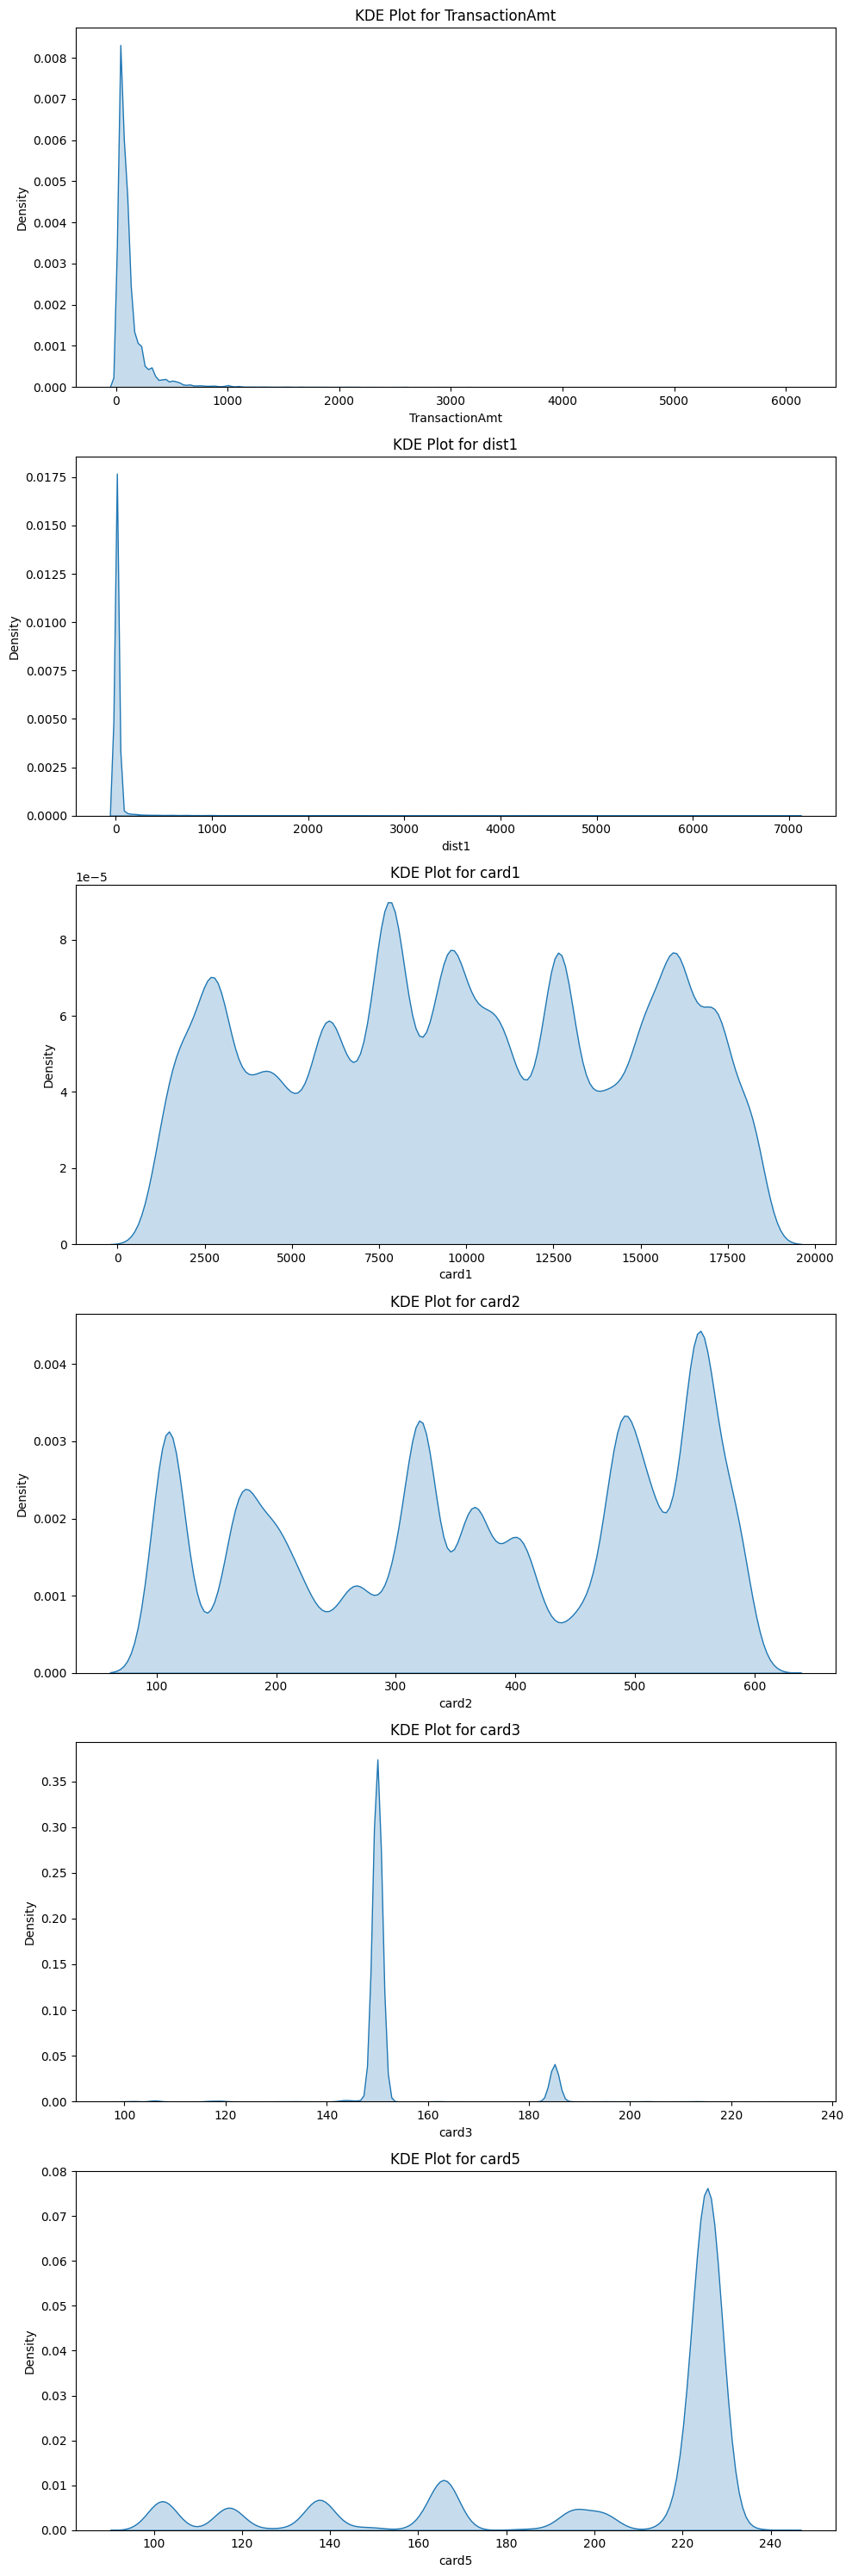

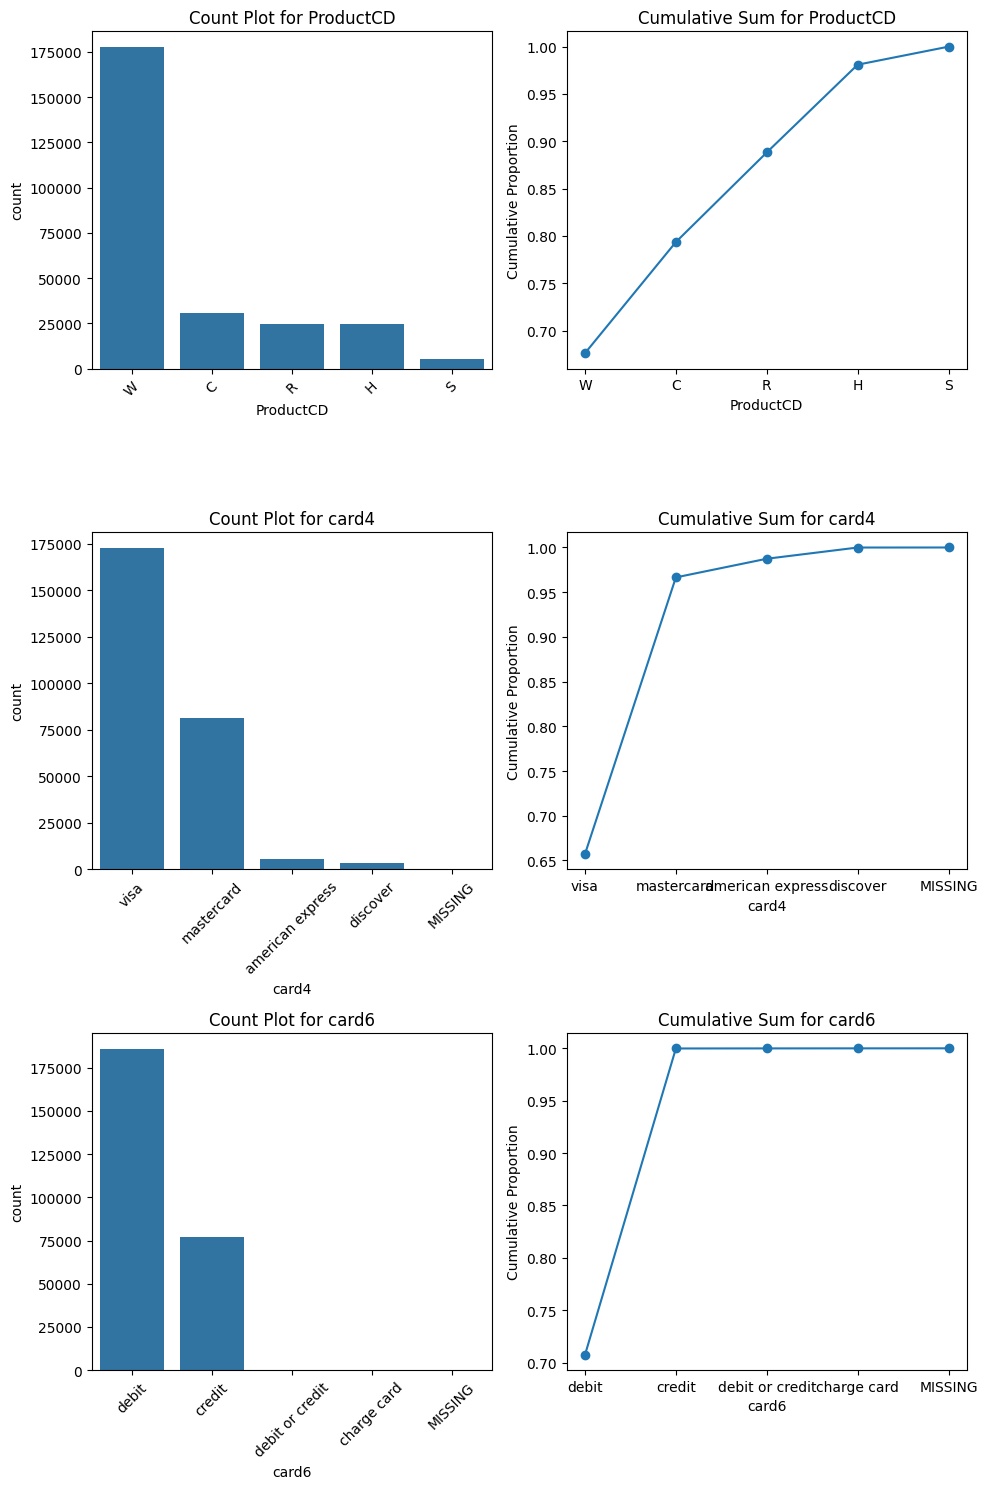

In [6]:
visualize_distributions(processed_df, ['TransactionAmt', 'dist1', 'card1', 'card2', 'card3', 'card5'], ['ProductCD', 'card4', 'card6'])

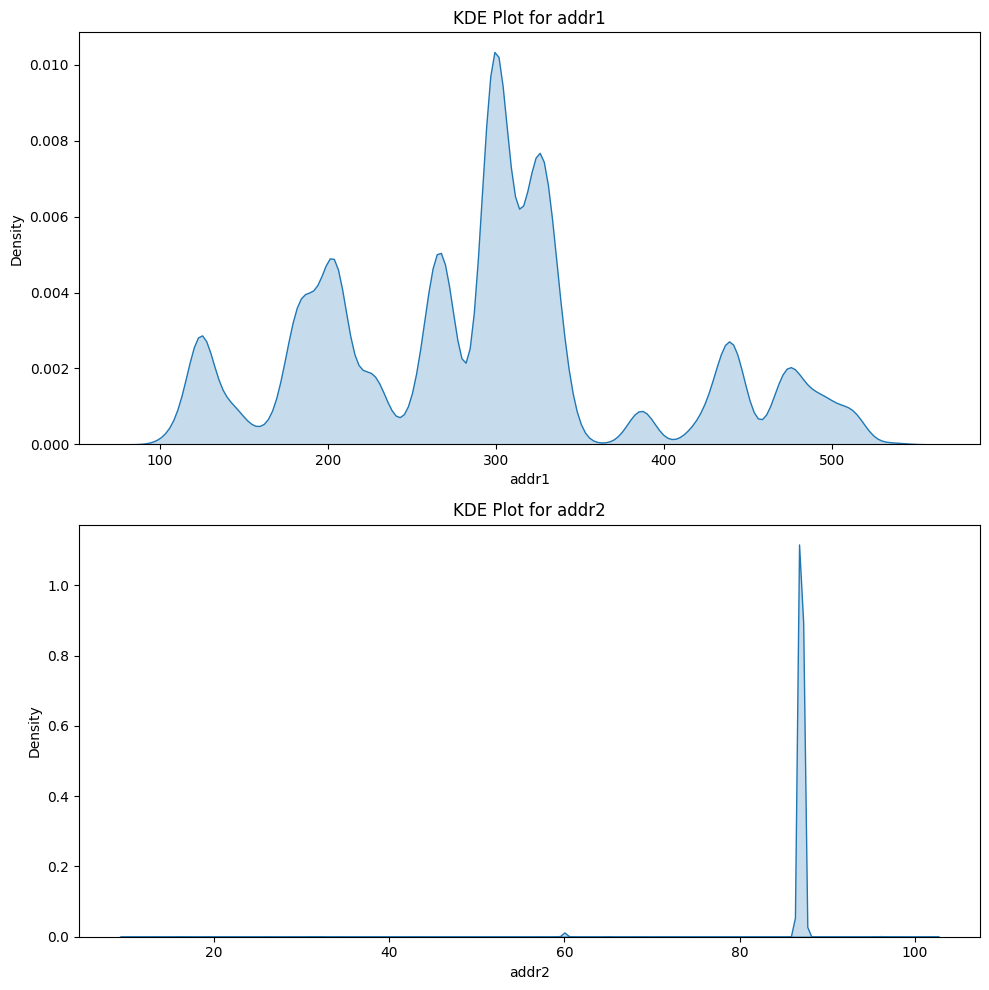

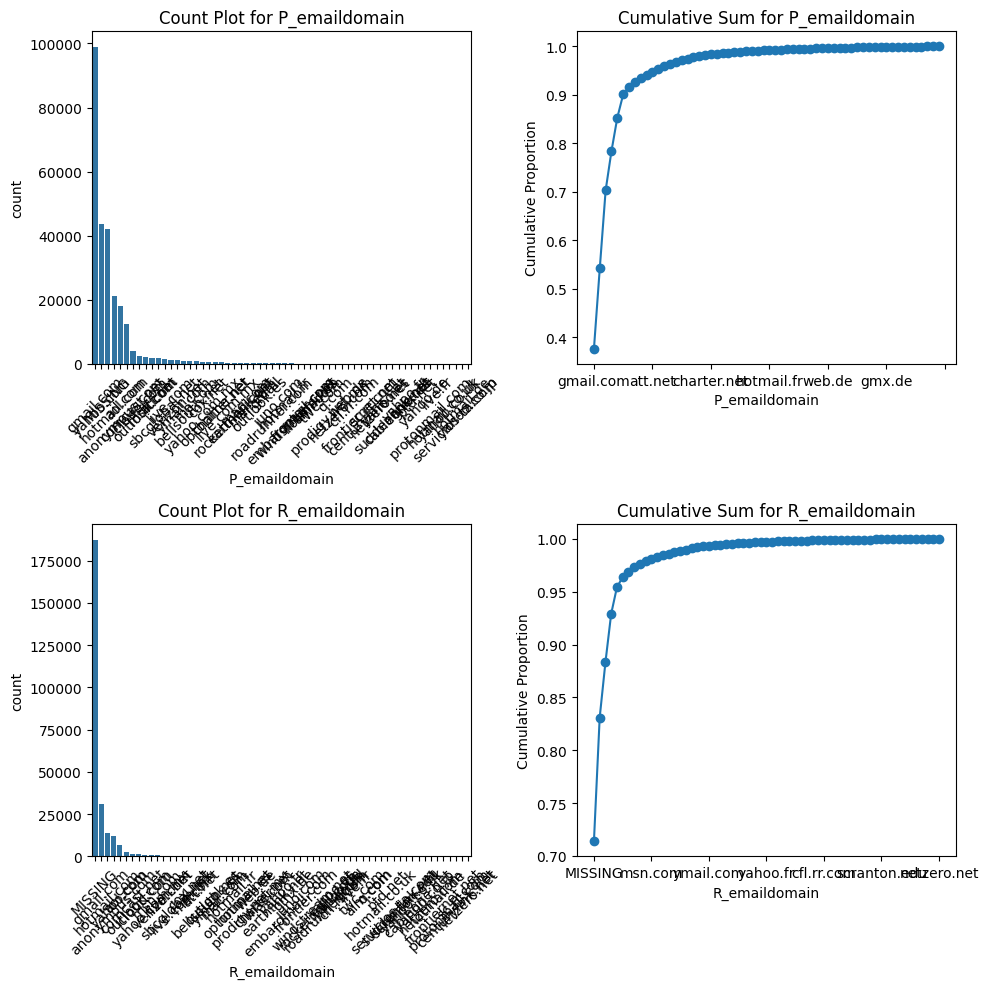

In [7]:
visualize_distributions(processed_df, ['addr1'], ['P_emaildomain', 'R_emaildomain'])

(array([36., 14.,  1.,  2.,  2.,  0.,  0.,  1.,  2.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.]),
 <BarContainer object of 20 artists>)

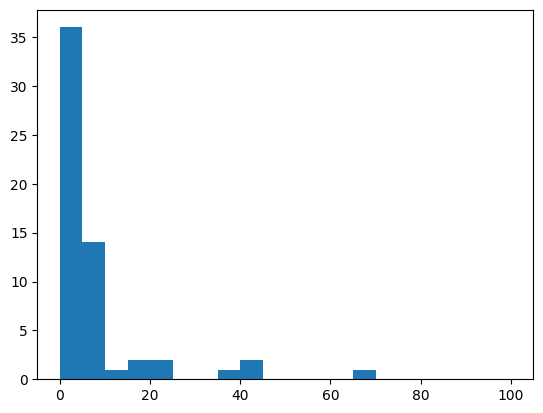

In [62]:
addr2 = processed_df.groupby('addr2').count()['TransactionID']
plt.hist(addr2, bins=20, range=(0.0, 100.0))

### Study Email Columns

In [8]:
def visualize_fraud_impact_by_category(df, categorical_cols, selected_categories=None, target_col='isFraud'):
    """
    Visualize the impact of each category on the classification by showing how many rows
    with a feature having a category from the set of all categories has value 1 in the 'isFraud' column.

    Parameters:
        df (pd.DataFrame): The dataset.
        categorical_cols (list): List of categorical columns to analyze.
        target_col (str): The target column indicating fraud (default is 'isFraud').
    """
    for i, col in enumerate(categorical_cols):
        # Calculate the count of fraud (isFraud = 1) for each category
        if selected_categories is not None:
            filter_df = df[df[col].isin(selected_categories[i])]
        else:
            filter_df = df
        fraud_counts = filter_df[filter_df[target_col] == 1].groupby(col, observed=True).size()
        total_counts = filter_df.groupby(col, observed=True).size()

        # Calculate the proportion of fraud for each category
        fraud_proportion = (fraud_counts / total_counts)

        # Plot the results
        plt.figure(figsize=(10, 6))
        sns.barplot(x=fraud_proportion.index.to_list(), y=fraud_proportion.values)
        plt.title(f'Proportion of Fraud by {col}')
        plt.xlabel(col)
        plt.ylabel('Proportion of Fraud')
        plt.xticks(rotation=45)
        plt.show()

In [9]:
def visualize_category_counts(df, feature_name, selected_categories):
    """
    Visualize the number of appearances in the dataframe of rows with the category value of the feature.

    Parameters:
        df (pd.DataFrame): The dataset.
        feature_name (str): The name of the categorical feature to analyze.
        selected_categories (list): List of selected categories to visualize.
    """
    # Filter the dataframe to include only the selected categories
    filtered_df = df[df[feature_name].isin(selected_categories)]

    # Count the occurrences of each selected category
    category_counts = filtered_df[feature_name].value_counts().reindex(selected_categories, fill_value=0)

    # Plot the results
    plt.figure(figsize=(10, 6))
    sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
    plt.title(f'Count of Rows for Selected Categories in {feature_name}')
    plt.xlabel(feature_name)
    plt.ylabel('Count of Rows')
    plt.xticks(rotation=45)
    plt.show()

In [10]:
def categories_with_high_impact(df, categorical_col, rate, target_col='isFraud'):
    # Calculate the count of fraud (isFraud = 1) for each category
    fraud_counts = df[df[target_col] == 1].groupby(categorical_col, observed=False).size()
    total_counts = df.groupby(categorical_col, observed=False).size()

    # Calculate the proportion of fraud for each category
    fraud_proportion = (fraud_counts / total_counts).fillna(0)
    return fraud_proportion[fraud_proportion > rate].index

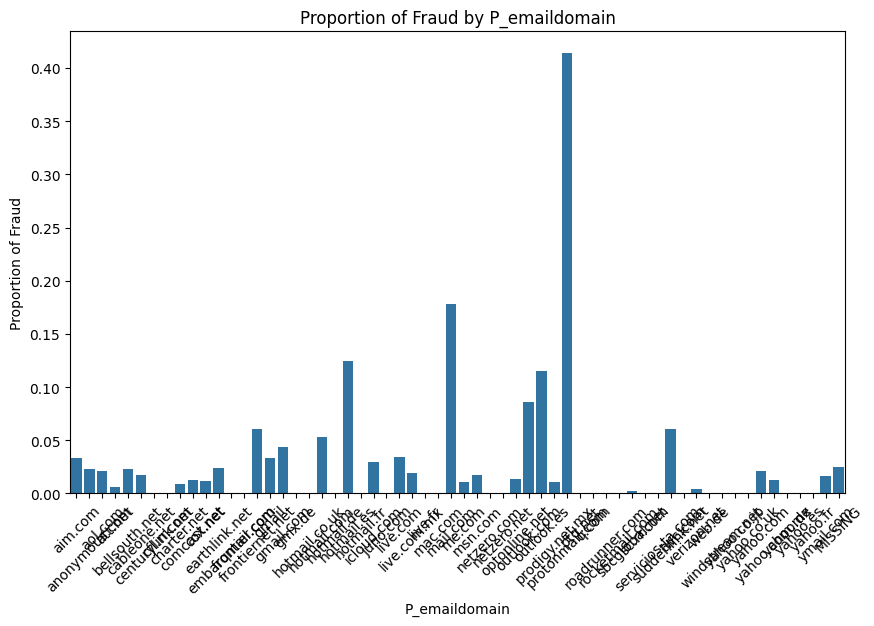

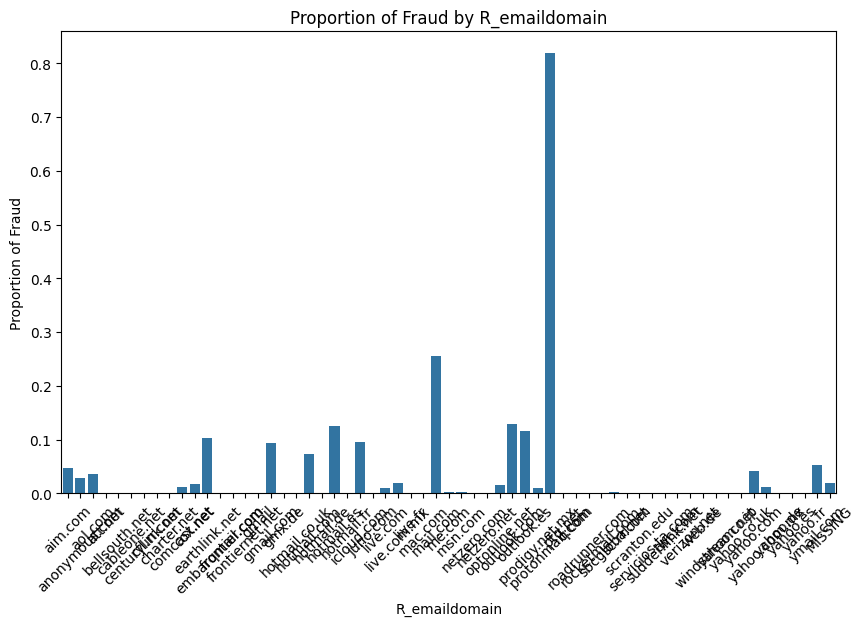

In [11]:
visualize_fraud_impact_by_category(processed_df, ['P_emaildomain', 'R_emaildomain'])

In [12]:
p_domain_high_impact_categories = categories_with_high_impact(processed_df, 'P_emaildomain', 0.05)
p_domain_high_impact_categories.to_list()

['frontiernet.net',
 'hotmail.com',
 'hotmail.es',
 'mail.com',
 'outlook.com',
 'outlook.es',
 'protonmail.com',
 'suddenlink.net']

In [13]:
r_domain_high_impact_categories = categories_with_high_impact(processed_df, 'R_emaildomain', 0.05)
r_domain_high_impact_categories.to_list()

['earthlink.net',
 'gmail.com',
 'hotmail.com',
 'hotmail.es',
 'icloud.com',
 'mail.com',
 'outlook.com',
 'outlook.es',
 'protonmail.com',
 'ymail.com']

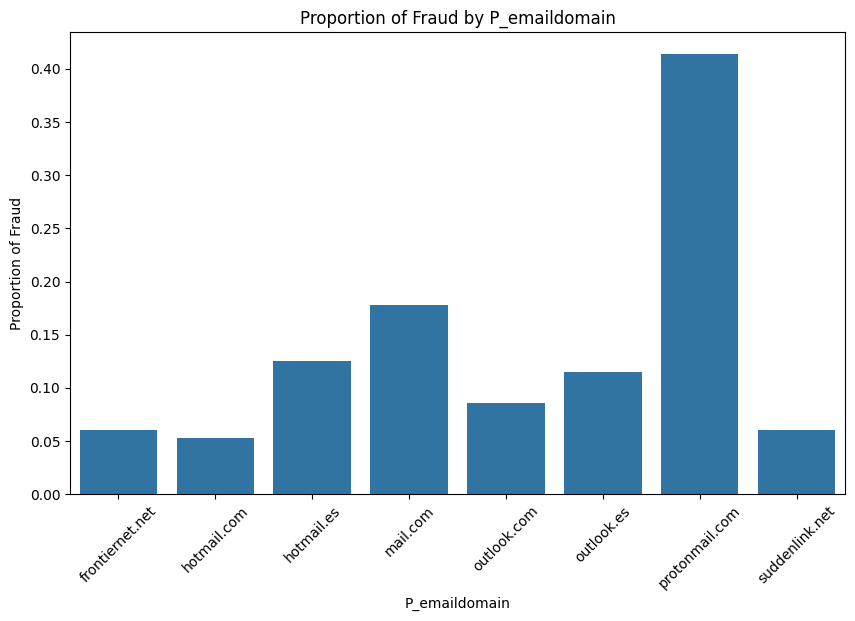

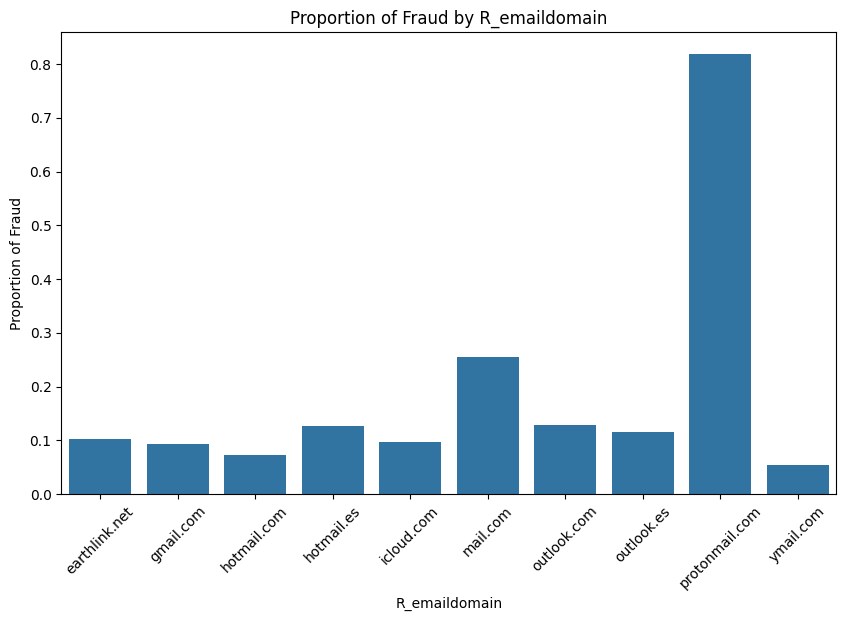

In [14]:
visualize_fraud_impact_by_category(processed_df, ['P_emaildomain', 'R_emaildomain'], [p_domain_high_impact_categories.to_list(), r_domain_high_impact_categories.to_list()])

<ipython-input-9-983874c249eb>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


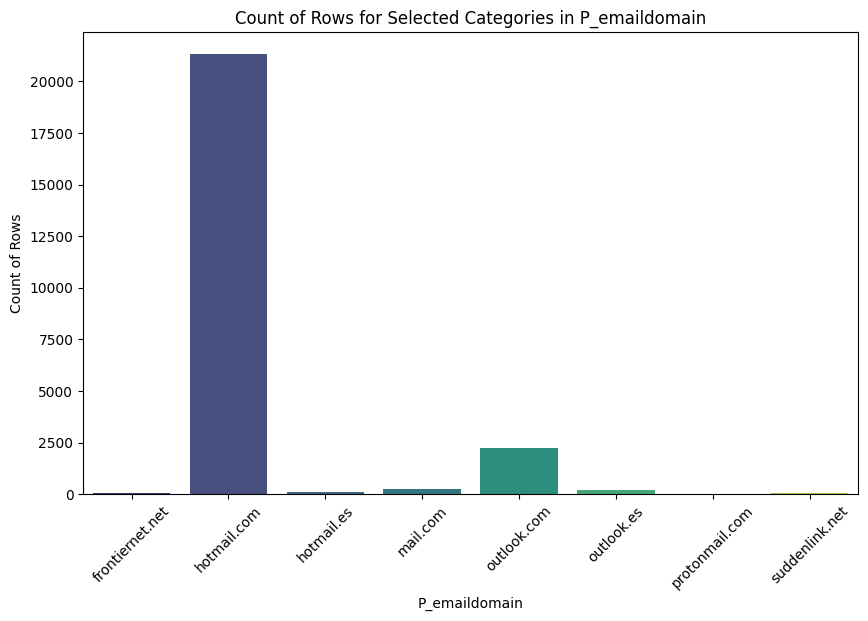

In [15]:
visualize_category_counts(processed_df, 'P_emaildomain', p_domain_high_impact_categories.to_list())

<ipython-input-9-983874c249eb>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


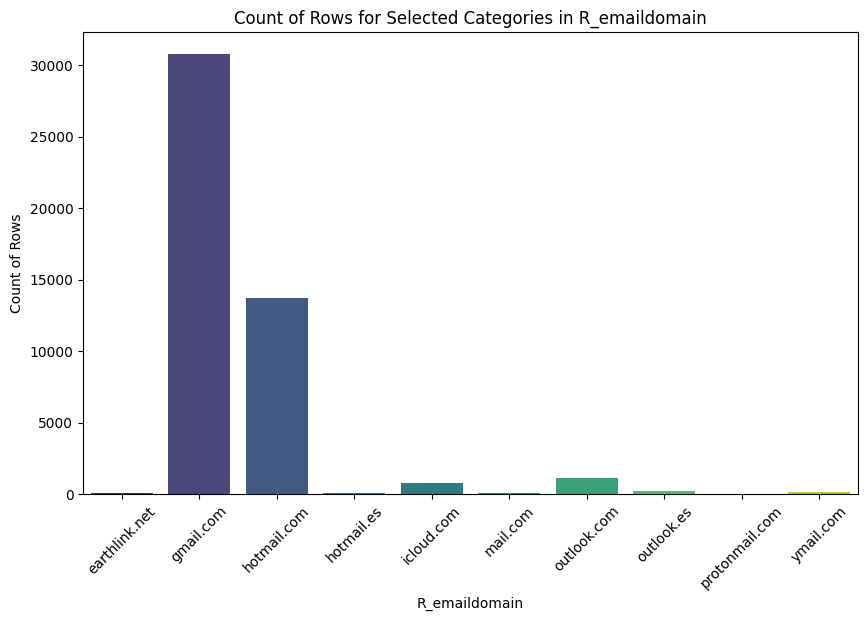

In [16]:
visualize_category_counts(processed_df, 'R_emaildomain', r_domain_high_impact_categories.to_list())

### Transform Email Columns

In [17]:
p_groups = set(p_domain_high_impact_categories)
r_groups = set(r_domain_high_impact_categories)

# Create a function to apply the encoding rules
def encode_domain(email, groups):
    if email == 'protonmail.com':
        return 2
    elif email in groups:
        return 1
    else:
        return 0

# Apply the encoding to 'P_emaildomain' and 'R_emaildomain'
processed_df['P_emaildomain'] = processed_df.apply(
    lambda row: encode_domain(row['P_emaildomain'], p_groups),
    axis=1
)
processed_df['R_emaildomain'] = processed_df.apply(
    lambda row: encode_domain(row['R_emaildomain'], r_groups),
    axis=1
)

### M columns

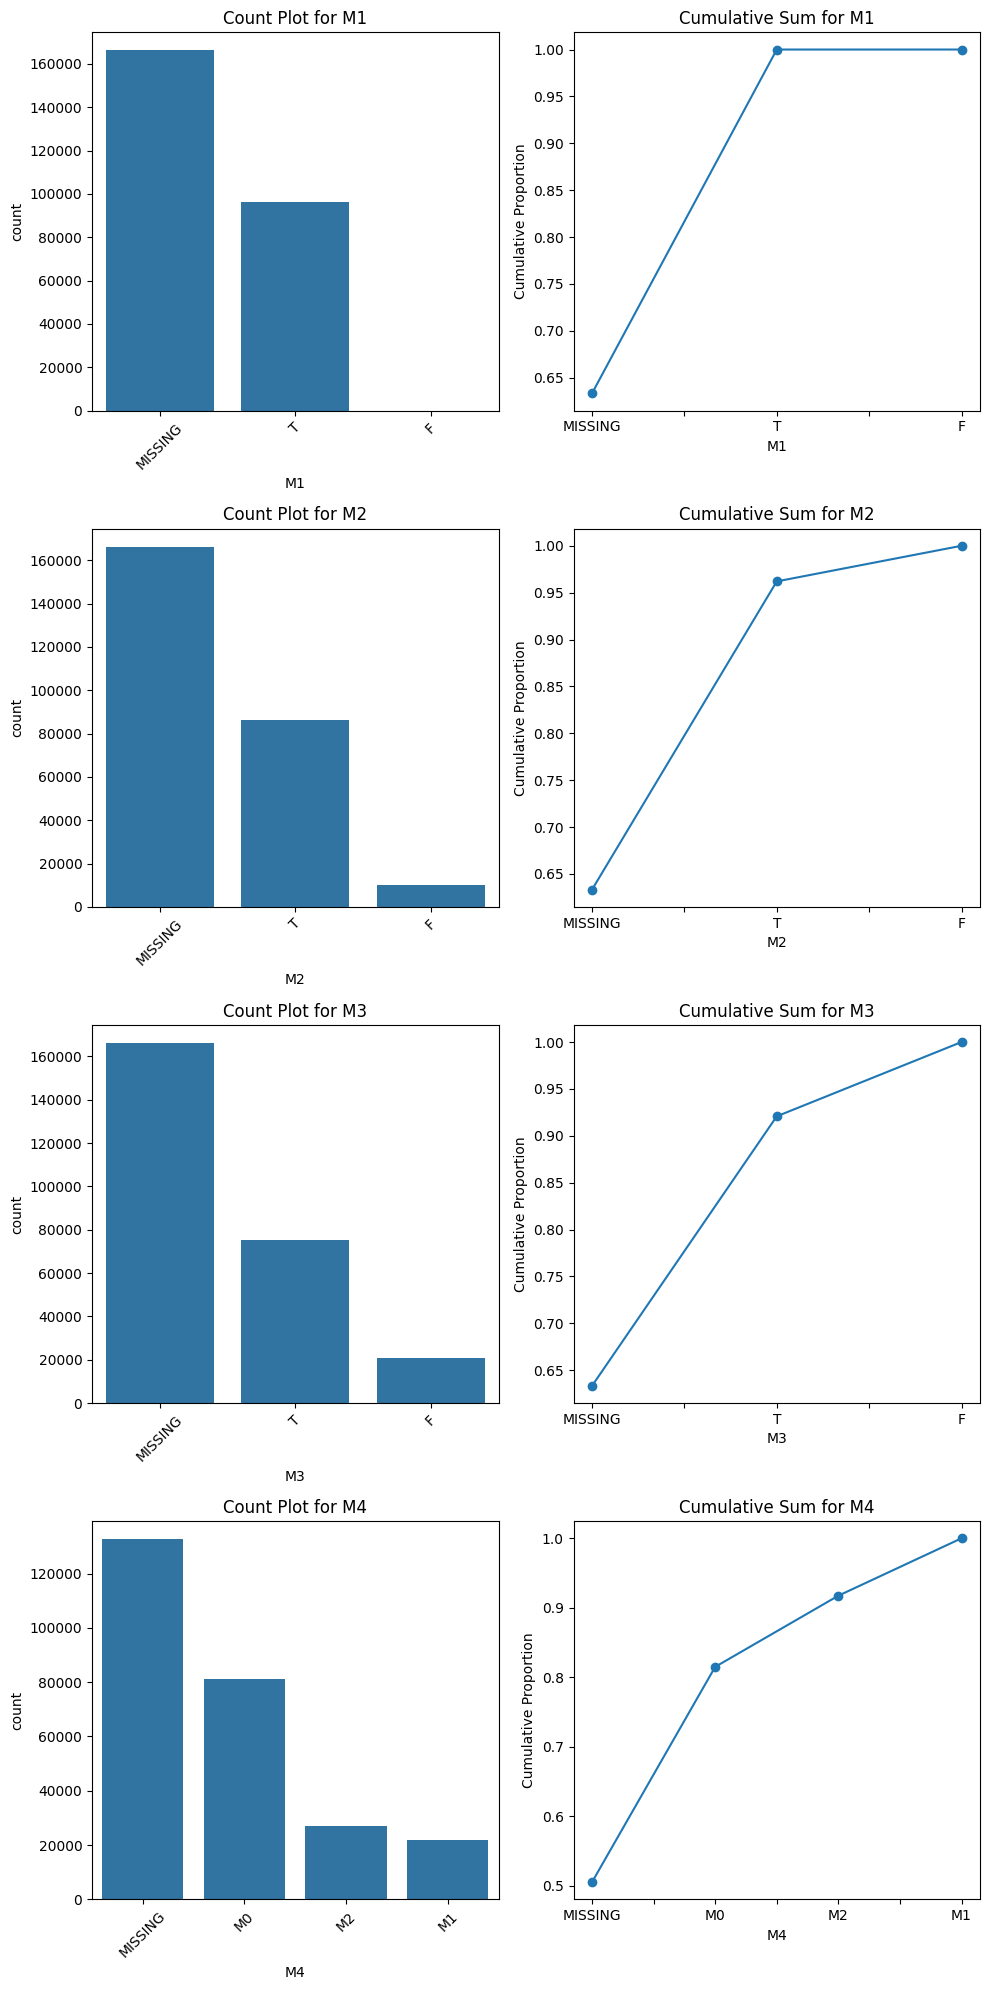

In [18]:
visualize_distributions(processed_df, [], ['M1', 'M2', 'M3', 'M4'])

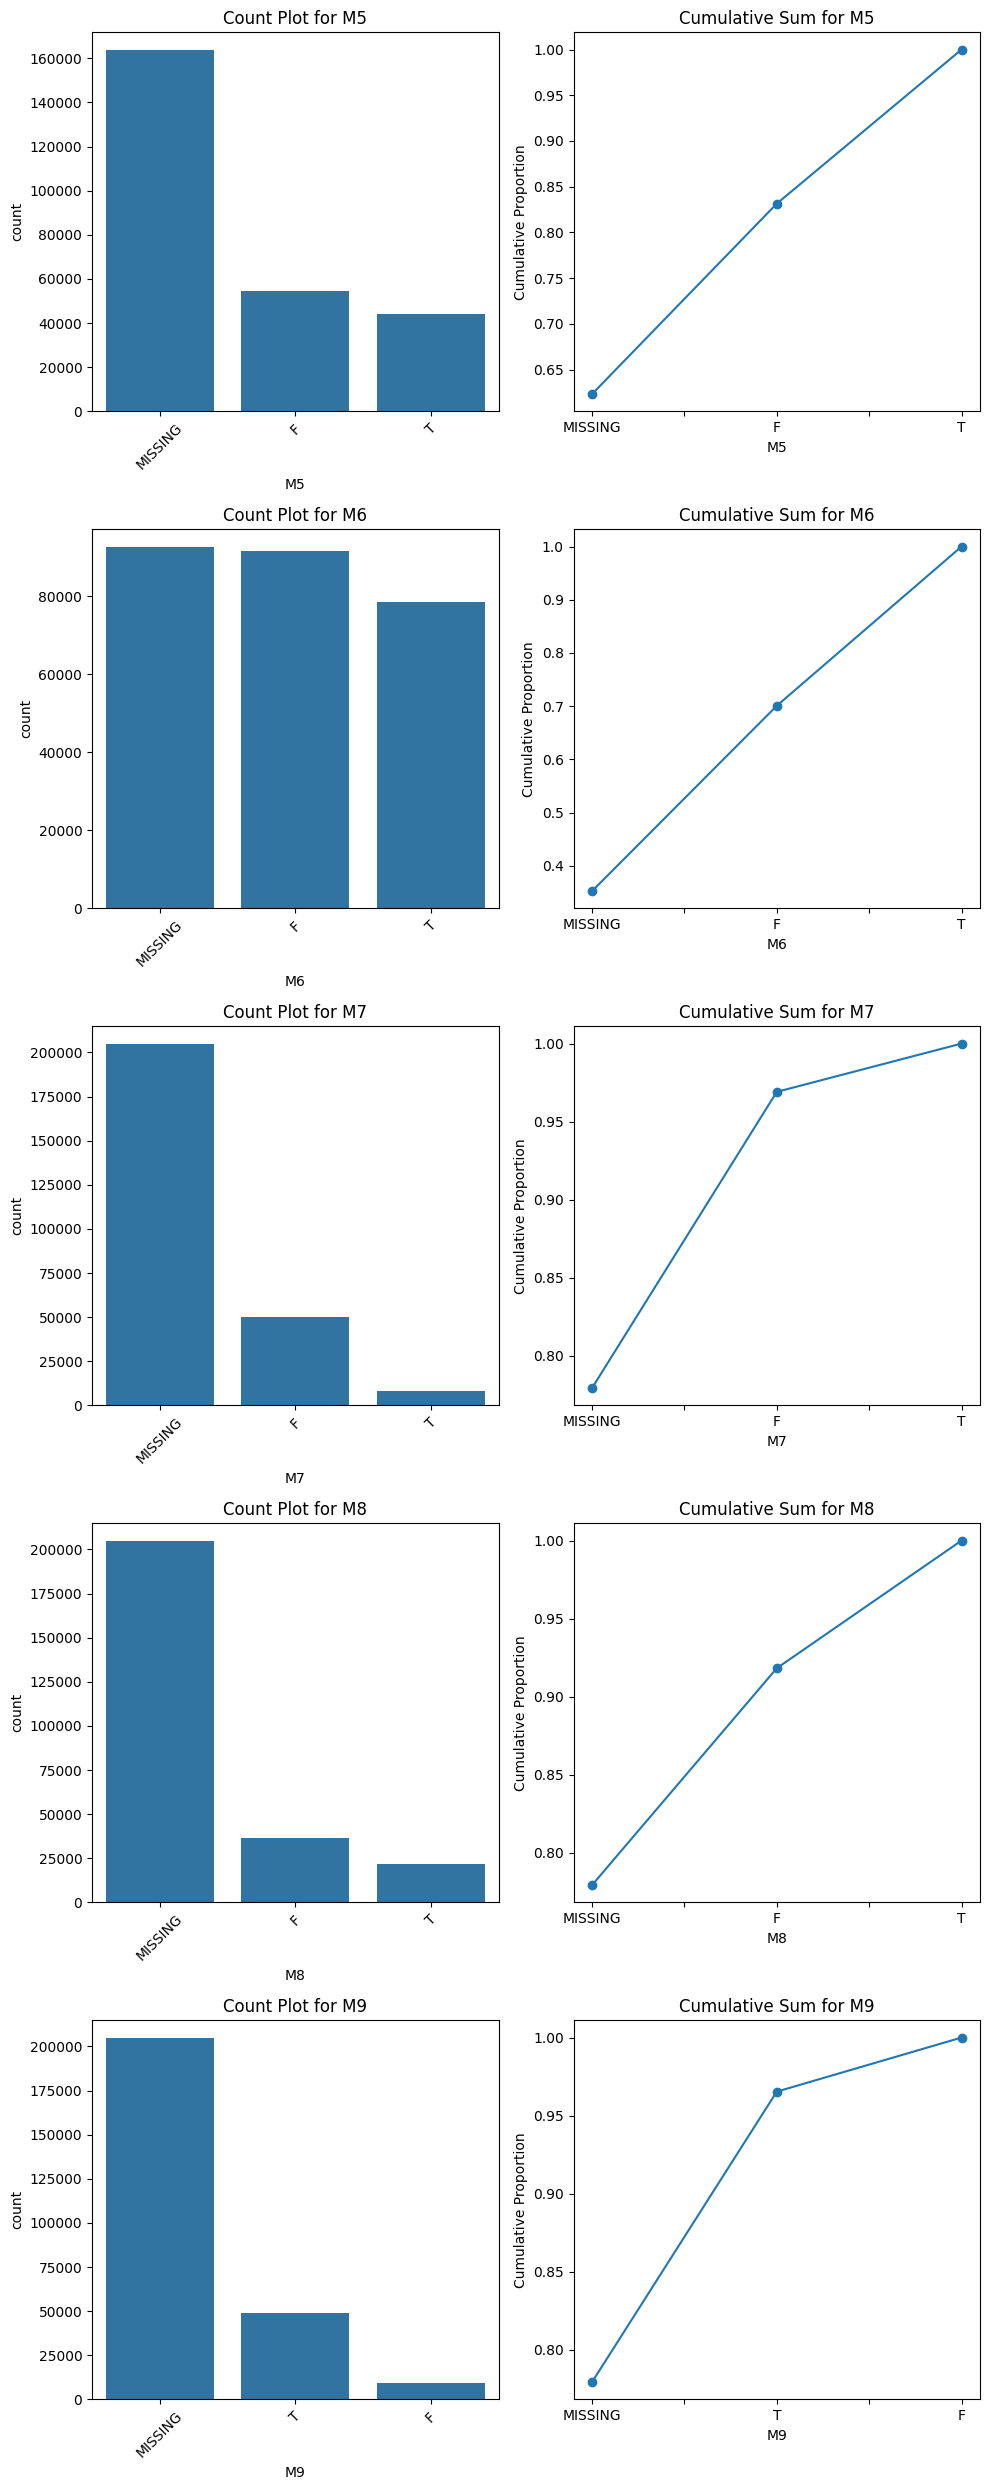

In [19]:
visualize_distributions(processed_df, [], ['M5', 'M6', 'M7', 'M8', 'M9'])

In [20]:
# Create a function to apply the encoding rules
def encode_match(value):
    if value == 'F':
        return 2
    elif value == 'MISSING':
        return 1
    else:
        return 0

for m in range(1, 10):
    if m == 4:
        continue
    column_name = f"M{m}"

    processed_df[column_name] = processed_df.apply(
        lambda row: encode_match(row[column_name]),
        axis=1
    )

### Vesta engineered rich features

In [21]:
len([name for name in processed_df.columns if name.startswith('V')])

339

### Identity Information

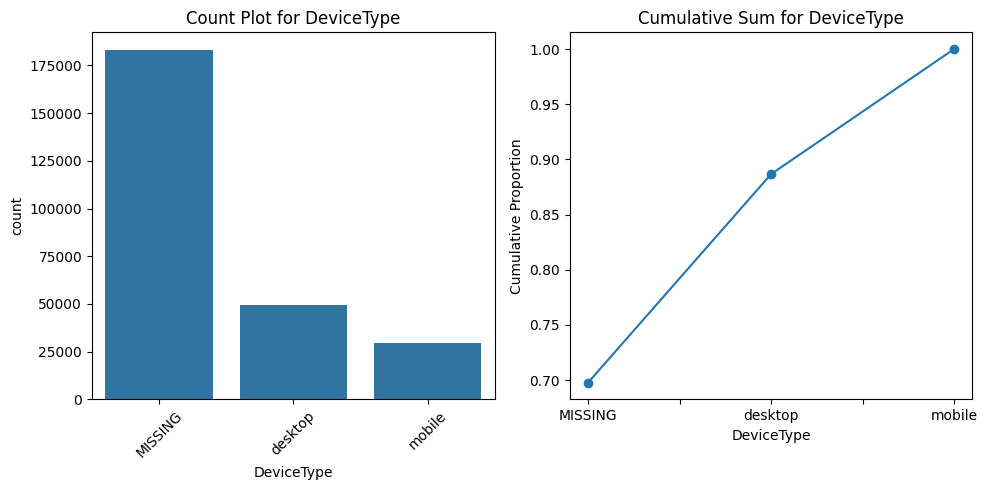

In [22]:
visualize_distributions(processed_df, [], ['DeviceType'])

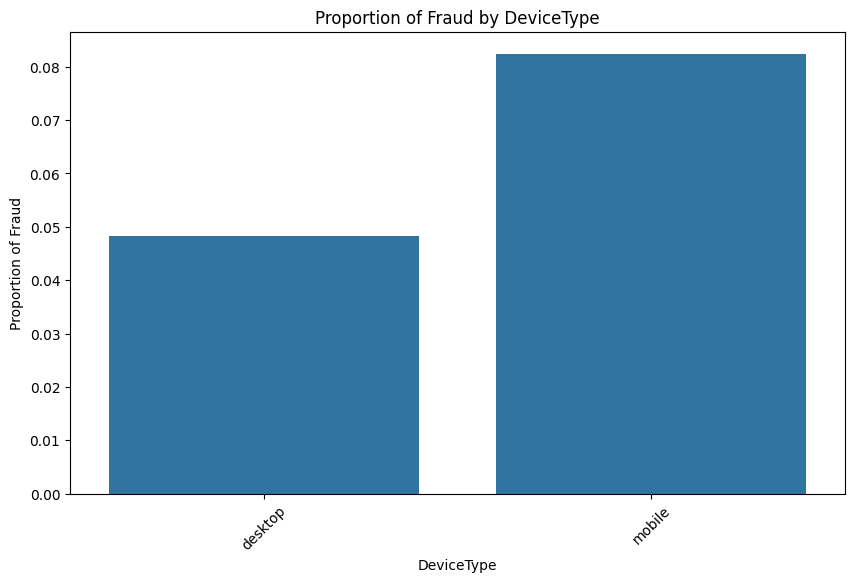

In [23]:
visualize_fraud_impact_by_category(processed_df, ['DeviceType'], [['desktop', 'mobile']])

<ipython-input-24-93df8e59ed7b>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  info_counts = processed_df.groupby('DeviceInfo').count()['TransactionID']


Missing proportion: 0.7362692189041273


(array([868., 297., 171.,  95.,  54.,  36.,  36.,  30.,  21.,  18.,  16.,
         12.,  15.,   5.,   9.,   2.,   9.,   9.,   5.,   5.,   6.,   4.,
          3.,   6.,   6.,   3.,   5.,   1.,   2.,   1.,   1.,   1.,   1.,
          0.,   1.,   2.,   0.,   1.,   0.,   0.,   1.,   3.,   0.,   0.,
          2.,   1.,   0.,   0.,   1.,   2.]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
         22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
         44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
         66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
         88.,  90.,  92.,  94.,  96.,  98., 100.]),
 <BarContainer object of 50 artists>)

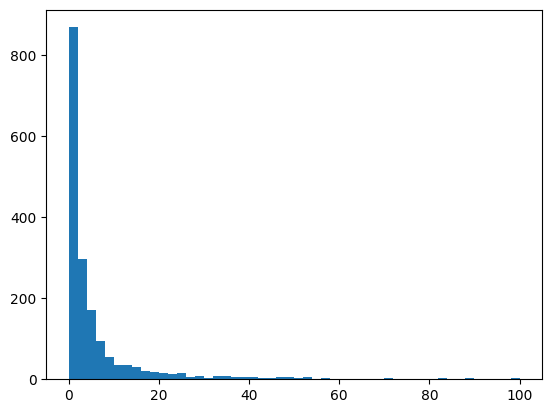

In [24]:
info_counts = processed_df.groupby('DeviceInfo').count()['TransactionID']
print(f"Missing proportion: {info_counts['MISSING'] / info_counts.sum()}")
plt.hist(info_counts.values, bins=50, range=(0.0, 100.0))

### ID columns

In [25]:
print([name for name in processed_df.columns if name.startswith('id')])

['id_01', 'id_02', 'id_05', 'id_06', 'id_11', 'id_12', 'id_13', 'id_15', 'id_16', 'id_17', 'id_19', 'id_20', 'id_28', 'id_29', 'id_31', 'id_35', 'id_36', 'id_37', 'id_38']


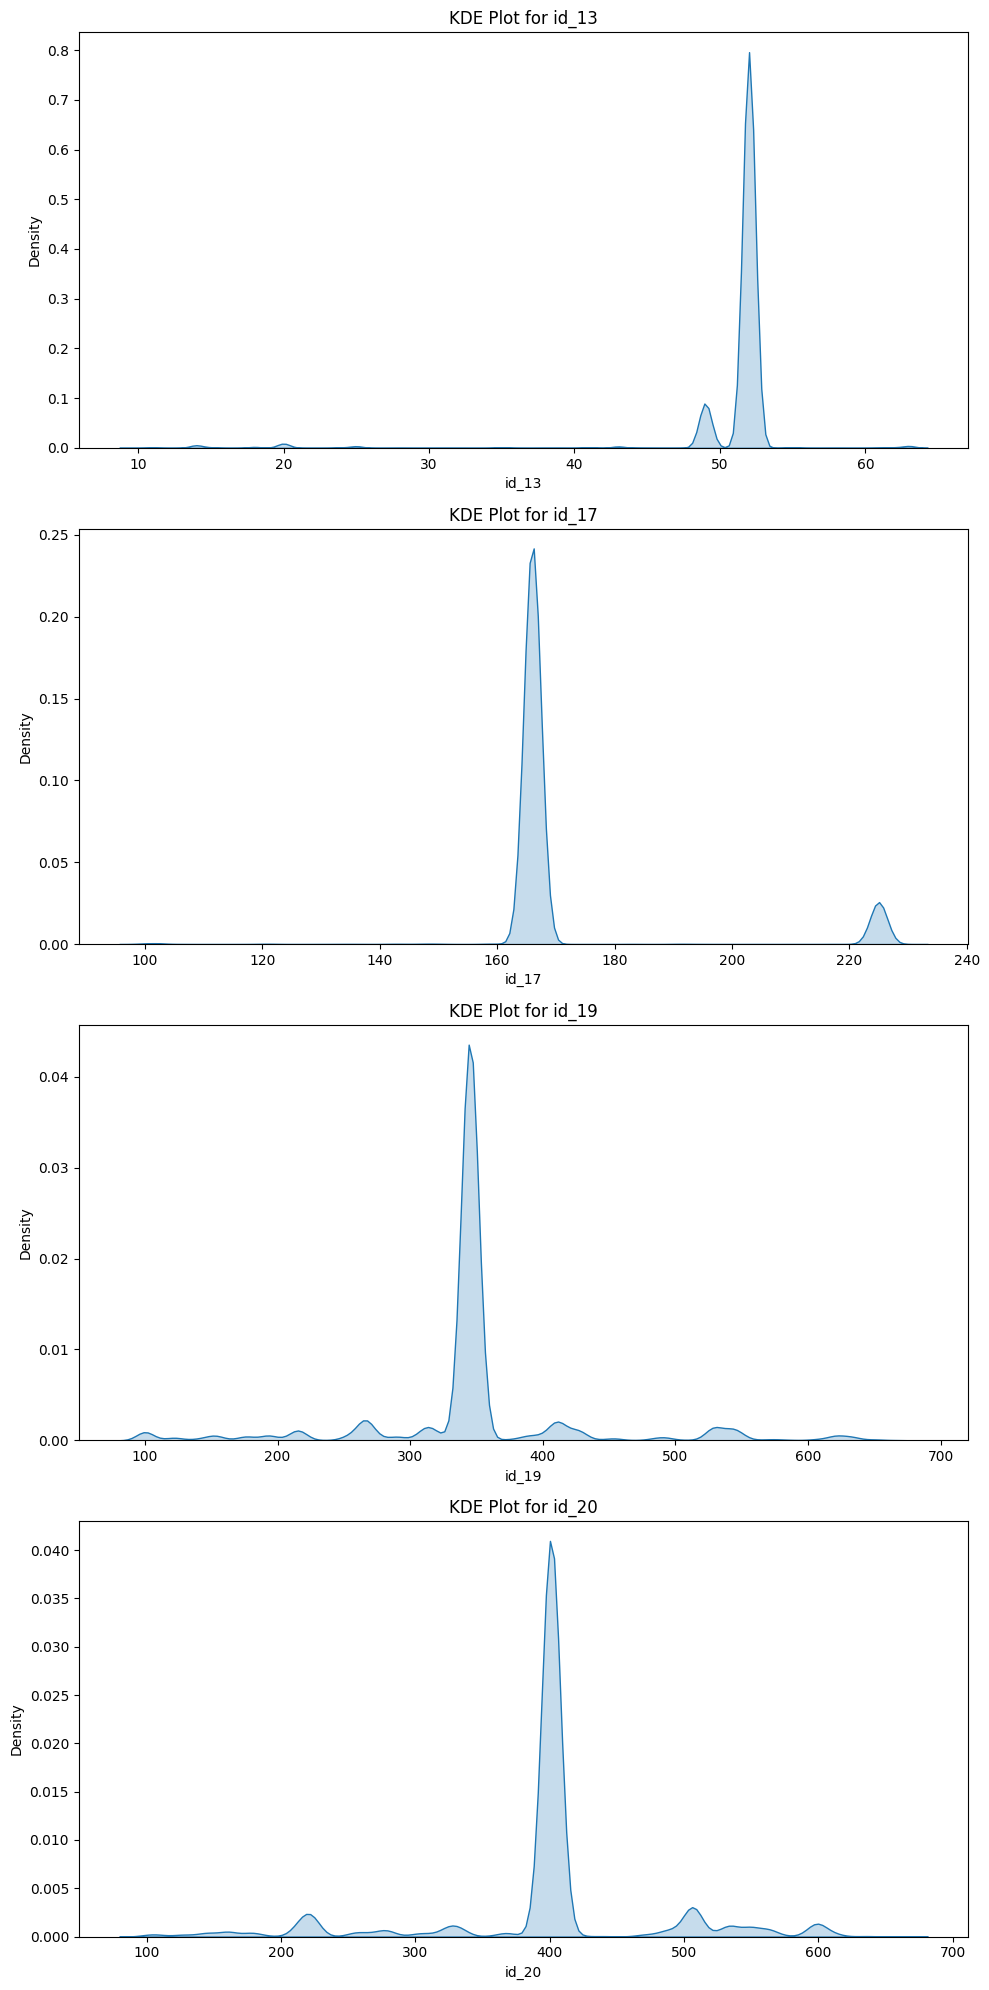

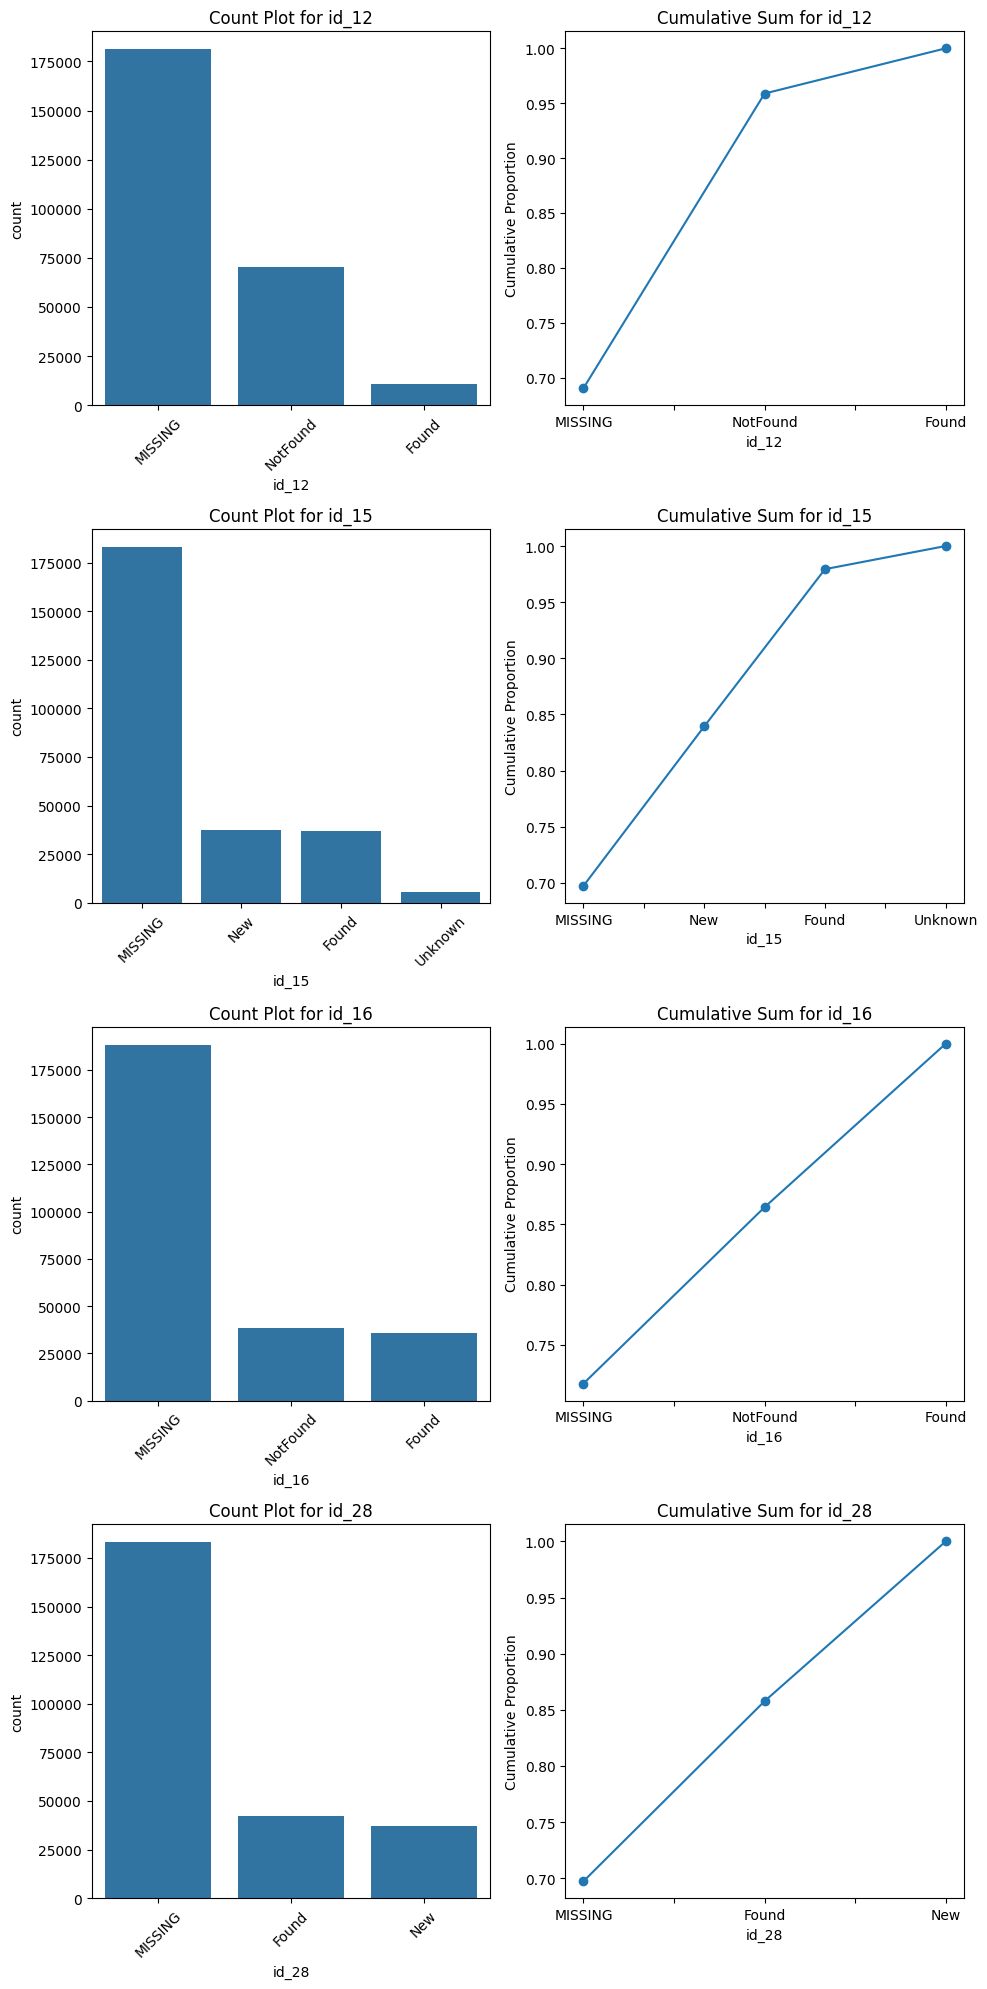

In [26]:
visualize_distributions(processed_df, ['id_13', 'id_17', 'id_19', 'id_20'], ['id_12', 'id_15', 'id_16', 'id_28'])

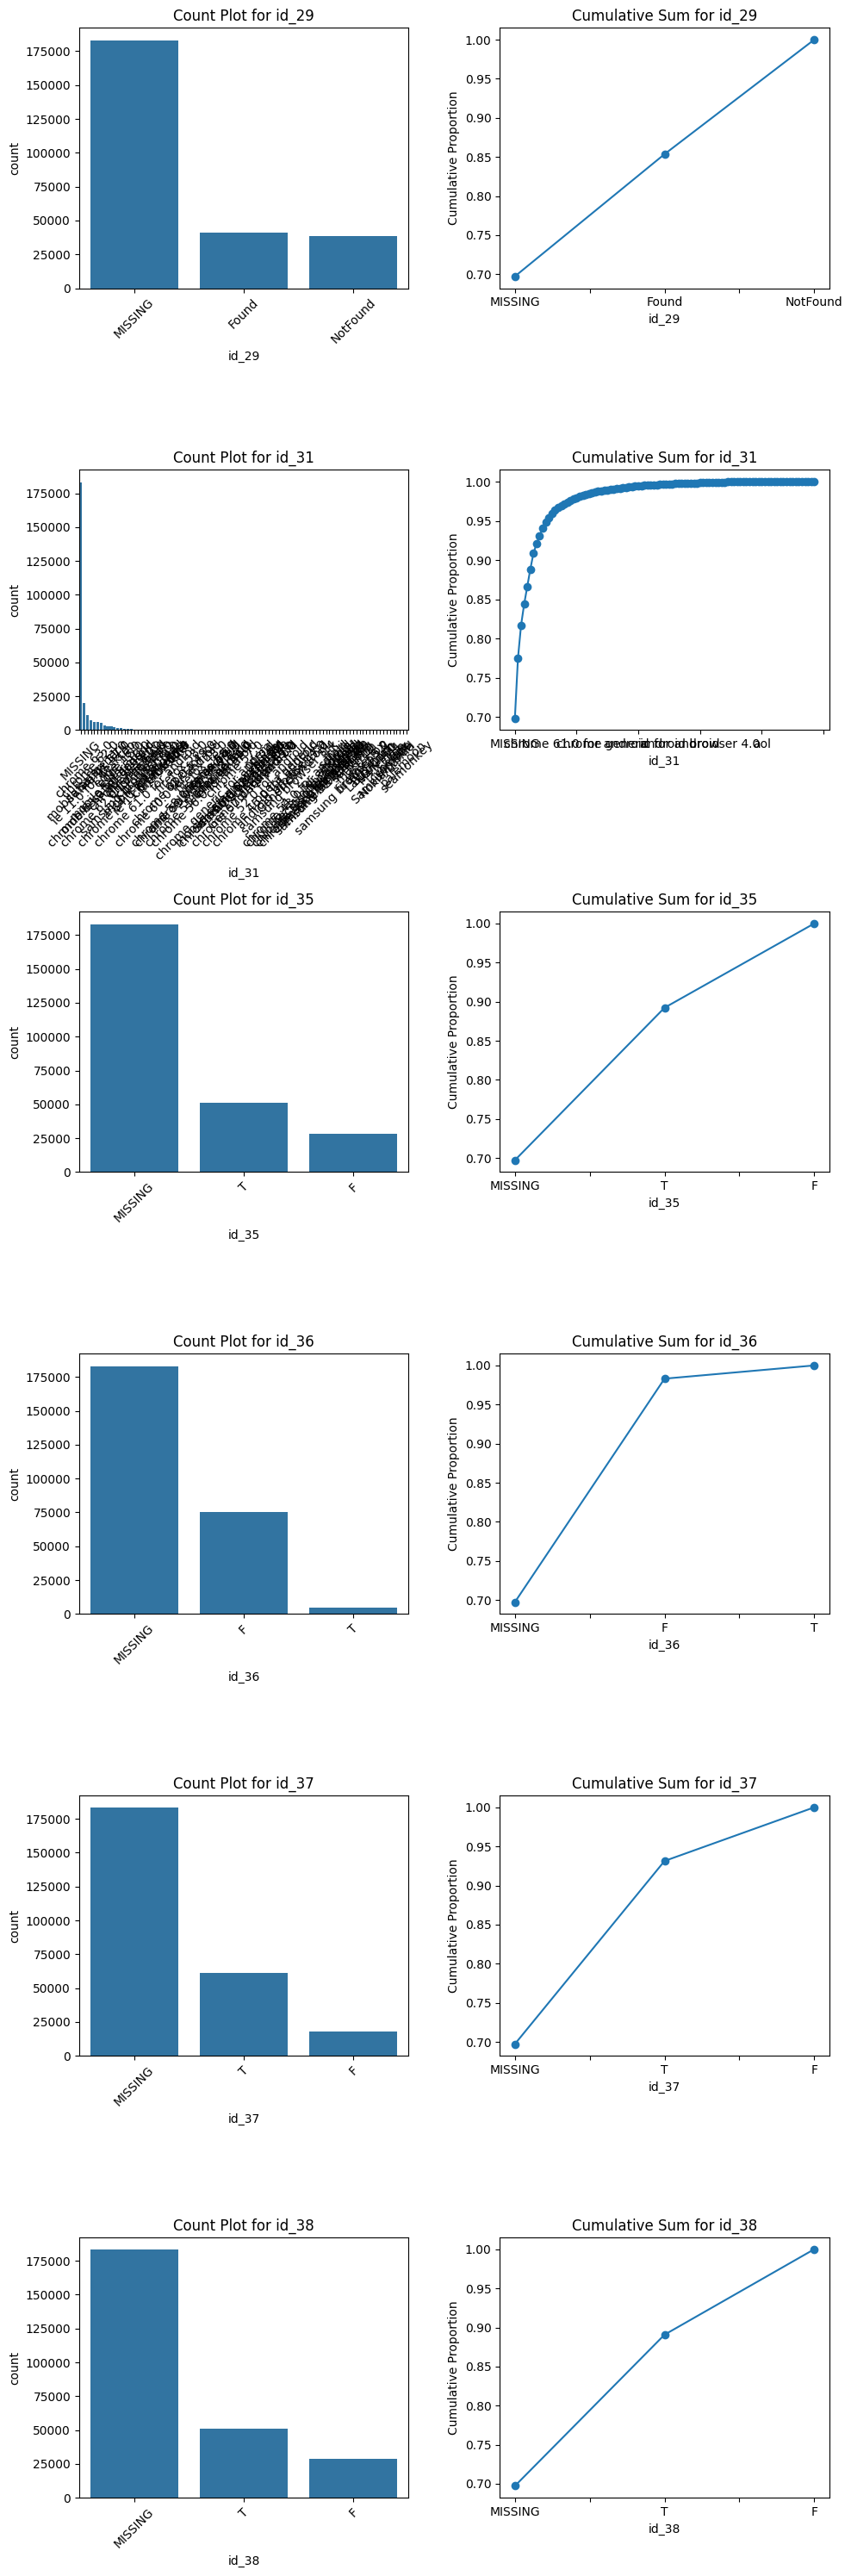

In [27]:
visualize_distributions(processed_df, [], ['id_29', 'id_31', 'id_35', 'id_36', 'id_37', 'id_38'])

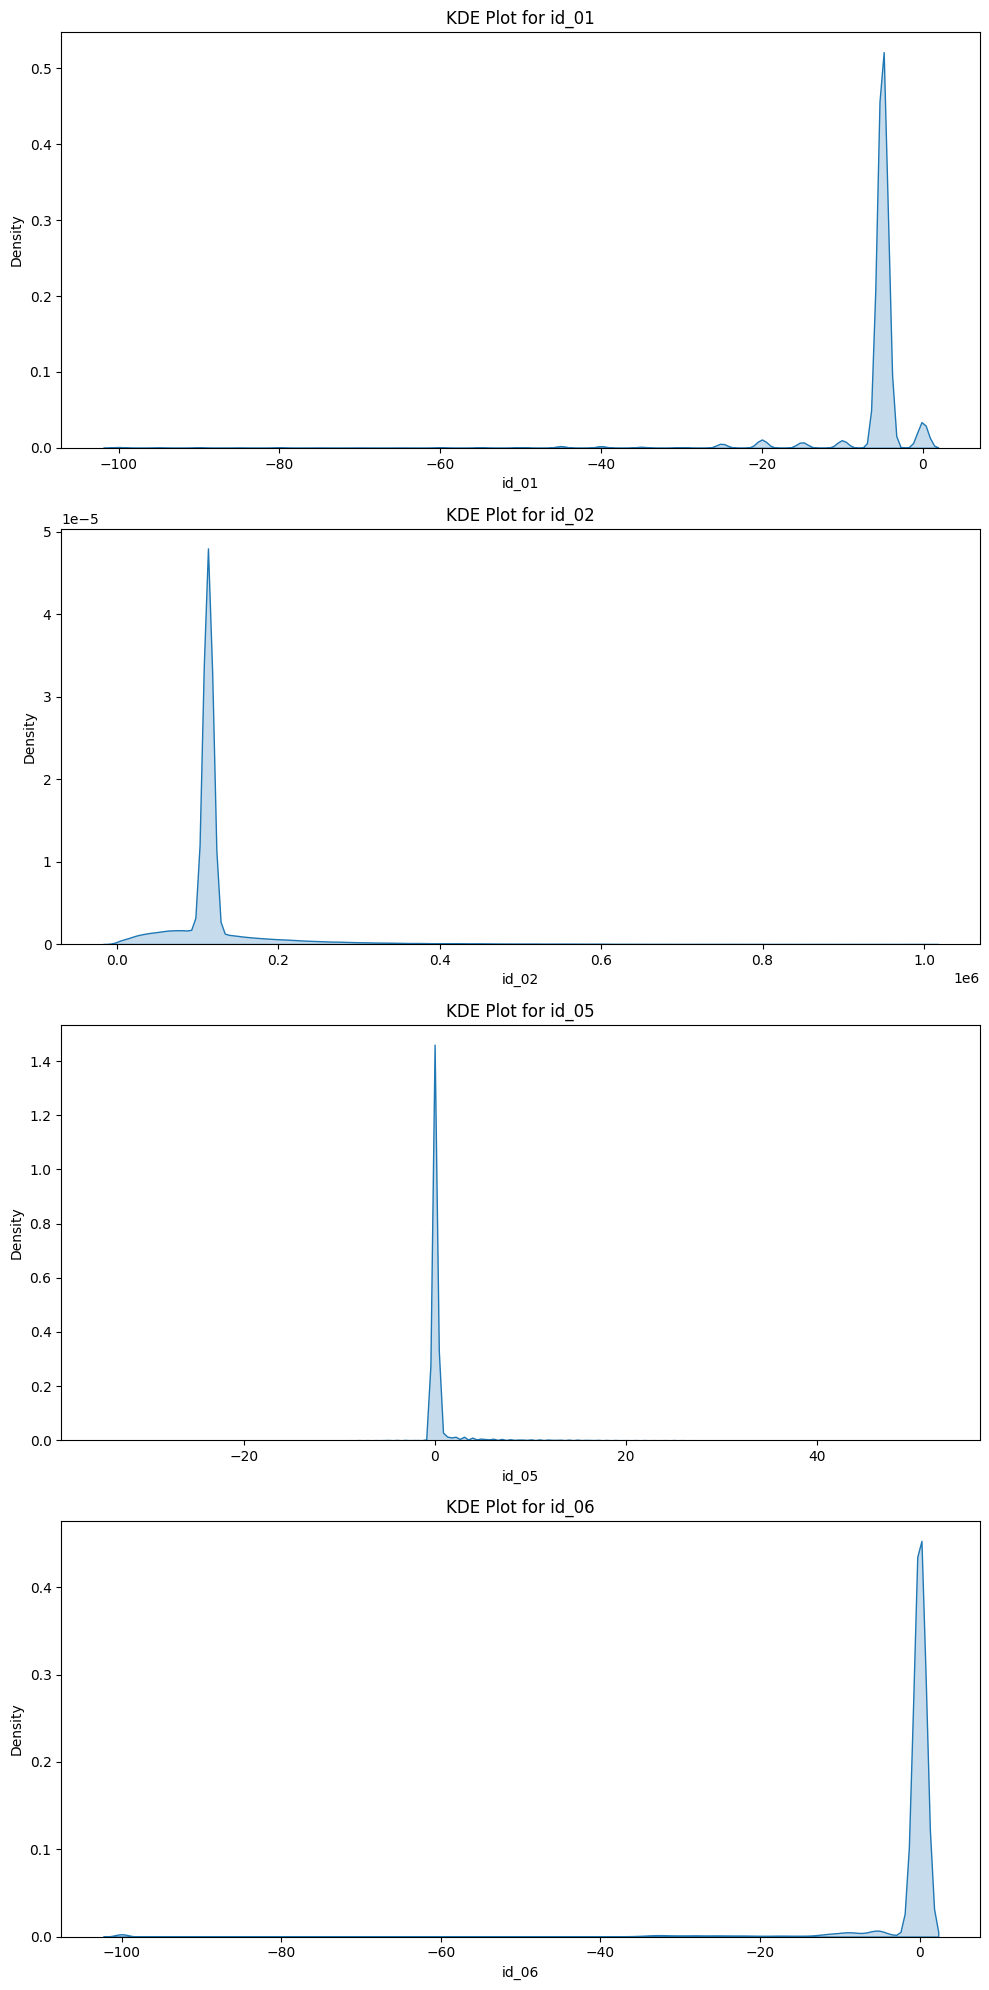

In [28]:
visualize_distributions(processed_df, ['id_01', 'id_02', 'id_05', 'id_06'], [])

<ipython-input-41-5c422a581b2a>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  browser_counts = processed_df.groupby('id_31').count()['TransactionID']


Missing proportion: 0.6980999135458759


(array([74.,  8.,  2.,  1.,  1.,  1.,  1.,  0.,  2.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([    0.,   300.,   600.,   900.,  1200.,  1500.,  1800.,  2100.,
         2400.,  2700.,  3000.,  3300.,  3600.,  3900.,  4200.,  4500.,
         4800.,  5100.,  5400.,  5700.,  6000.,  6300.,  6600.,  6900.,
         7200.,  7500.,  7800.,  8100.,  8400.,  8700.,  9000.,  9300.,
         9600.,  9900., 10200., 10500., 10800., 11100., 11400., 11700.,
        12000., 12300., 12600., 12900., 13200., 13500., 13800., 14100.,
  

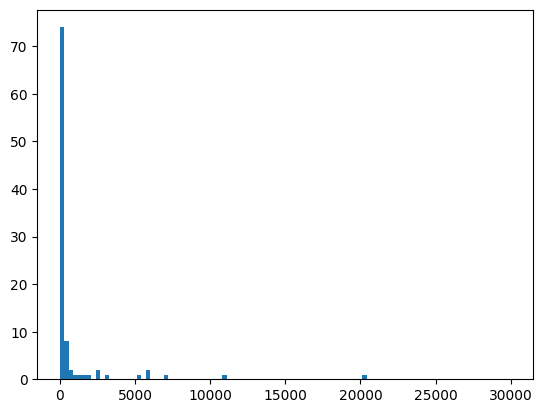

In [41]:
browser_counts = processed_df.groupby('id_31').count()['TransactionID']
print(f"Missing proportion: {browser_counts['MISSING'] / browser_counts.sum()}")
plt.hist(browser_counts.values, bins=100, range=(0.0, 30000.0))

### Remove redundant features

In [63]:
redundant_features.append('DeviceInfo') # sparse and rare categories with 70% missing rate
redundant_features.append('id_31')  # sparse and rare categories with almost 70% missing rate

In [79]:
processed_df = processed_df.drop(columns=redundant_features)

In [80]:
processed_df.select_dtypes(include=['category', 'object']).columns.tolist()

['ProductCD',
 'card4',
 'card6',
 'M4',
 'id_12',
 'id_15',
 'id_16',
 'id_28',
 'id_29',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType']

### Save dataframe

In [81]:
processed_df.to_parquet('explored_fraud_data.parquet', index=False)

## Encoding rest of categorical features

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy.sparse import csr_matrix

def handle_categorical_data(input_path, output_path, threshold=0.05):
    """
    One-Hot Encoding of categorical features
    """
    # Data loading
    df = pd.read_parquet(input_path)

    # Categorical features selection
    categorical_cols = df.select_dtypes(include=['category', 'object']).columns.tolist()

    # Rare categories filtration
    for col in categorical_cols:
        if df[col].nunique() > 100:
            df[col] = df[col].astype('category').cat.add_categories(['RARE_CATEGORY'])
            counts = df[col].value_counts(normalize=True)
            mask = df[col].isin(counts[counts < threshold].index)
            df.loc[mask, col] = 'RARE_CATEGORY'
            df[col] = df[col].cat.remove_unused_categories()

    # OneHotEncoder initialization with sparsed output
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(
                handle_unknown='ignore',
                sparse_output=True  # For sklearn >= 1.2 use sparse_output
            ), categorical_cols)
        ],
        remainder='passthrough'
    )

    transformed_data = preprocessor.fit_transform(df)

    # DataFrame creation
    encoded_df = pd.DataFrame(
        transformed_data,
        columns=preprocessor.get_feature_names_out()
    ).astype('float32')  # Memory optimisation

    # Saving
    encoded_df.to_parquet(output_path, index=False)
    return encoded_df

if __name__ == "__main__":
    # Usage example
    metadata = handle_categorical_data(
        input_path='explored_fraud_data.parquet',
        output_path='encoded_fraud_data.parquet',
        threshold=0.03
    )

## Learning Baseline

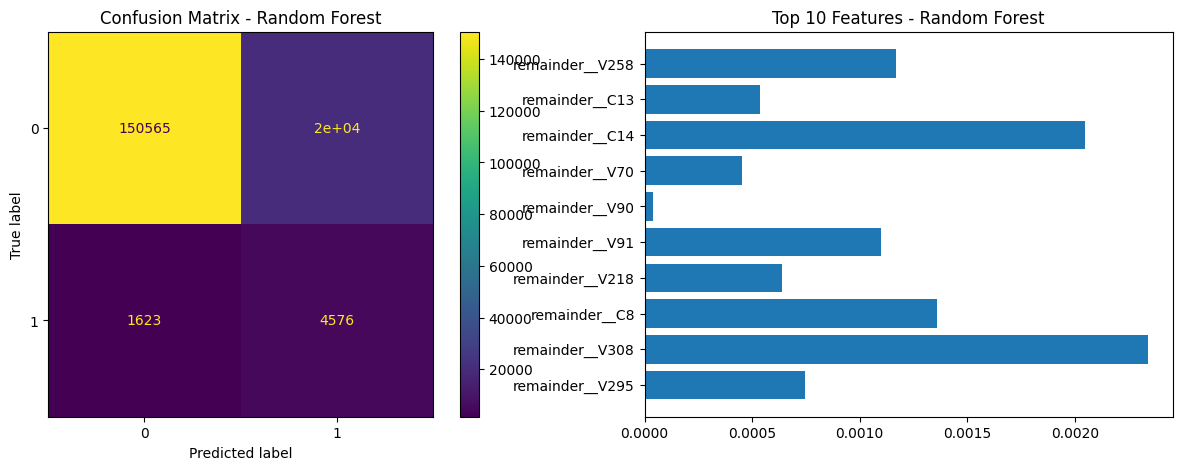

\nModel: Random Forest
ROC-AUC: 0.8849
PR-AUC: 0.5170
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93    170963
           1       0.18      0.74      0.29      6199

    accuracy                           0.88    177162
   macro avg       0.59      0.81      0.61    177162
weighted avg       0.96      0.88      0.91    177162



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt

def fraud_baseline(data_path: str, sample_frac: float = 1.0) -> dict:
    """Baseline pipeline for the model"""
    global target

    # Processed data loading
    X = pd.read_parquet(data_path)

    y = X[target_column]
    X = X.drop(columns=[target_column])

    # Stratified data split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.3,
        stratify=y,
        random_state=42
    )

    # Model initialization with optimization for classes disbalance
    models = {
        "Random Forest": RandomForestClassifier(
            class_weight='balanced_subsample',
            n_estimators=100,
            max_depth=10,
            n_jobs=-1
        ),
        # "XGBoost": XGBClassifier(
        #     scale_pos_weight=np.sqrt(len(y_train)/y_train.sum()),
        #     tree_method='hist',
        #     eval_metric='aucpr'
        # ),
        # "LightGBM": LGBMClassifier(
        #     class_weight='balanced',
        #     boosting_type='goss',
        #     objective='binary'
        # )
    }

    results = {}

    for name, model in models.items():
        # Model fit
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        # Metrics calculation
        metrics = {
            "roc_auc": roc_auc_score(y_test, y_proba),
            "pr_auc": average_precision_score(y_test, y_proba),
            "classification_report": classification_report(y_test, y_pred),
            "feature_importance": model.feature_importances_
        }
        results[name] = metrics

        # Visualization
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax[0])
        ax[0].set_title(f"Confusion Matrix - {name}")

        # Top 10 most valuable features
        top_features = X.columns[np.argsort(model.feature_importances_)[-10:]]
        ax[1].barh(top_features, model.feature_importances_[-10:])
        ax[1].set_title(f"Top 10 Features - {name}")
        plt.show()

    return results

if __name__ == "__main__":
    # Pipeline execution
    results = fraud_baseline(
        data_path='encoded_fraud_data.parquet',
        sample_frac=0.5  # For full dataset use 1.0
    )

    # Results output
    for model_name, metrics in results.items():
        print(f"\\nModel: {model_name}")
        print(f"ROC-AUC: {metrics['roc_auc']:.4f}")
        print(f"PR-AUC: {metrics['pr_auc']:.4f}")
        print("Classification Report:")
        print(metrics['classification_report'])